In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ngcthun","key":"7857157b9545dff6f383a9153eb77ae9"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!kaggle datasets download -d dansbecker/hot-dog-not-hot-dog

 94% 84.0M/89.3M [00:00<00:00, 186MB/s]
100% 89.3M/89.3M [00:00<00:00, 154MB/s]


In [4]:
!unzip -q hot-dog-not-hot-dog.zip

In [5]:
from pytorchcv import check_image_dir, common_transform, train, plot_results, display_dataset, train_mul, train_augs, test_augs, train_fine_tuning

In [6]:
check_image_dir('./test/hot_dog/*.jpg')
check_image_dir('./test/not_hot_dog/*.jpg')
check_image_dir('./train/hot_dog/*.jpg')
check_image_dir('./train/not_hot_dog/*.jpg')

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
!pip install torchinfo
from torchinfo import summary 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
trans = common_transform()
data_train = torchvision.datasets.ImageFolder('./train', transform = trans)
data_val = torchvision.datasets.ImageFolder('./test', transform = trans)

In [9]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size = 128, shuffle = True, pin_memory = True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size = 128, pin_memory = True)

In [10]:
finetune_net = torchvision.models.resnet18(pretrained = False)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Parameter containing:
tensor([[-0.0494,  0.0374, -0.0414,  ..., -0.0059, -0.1006,  0.0595],
        [ 0.1023, -0.0077, -0.0104,  ...,  0.0086, -0.0597, -0.0089]],
       requires_grad=True)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
finetune_net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
summary(finetune_net, input_size = [1,3,224,224])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [15]:
optimizer = torch.optim.SGD(finetune_net.parameters(), lr = 0.001, momentum = 0.9, nesterov = True)
hist = train_mul(finetune_net, train_loader, val_loader, optimizer = optimizer, epochs = 5, loss_fn = nn.CrossEntropyLoss())

Epoch  0, Train acc=0.498, Val acc=0.488, Train loss=0.009, Val loss=0.006, Time=10.827
Epoch  1, Train acc=0.534, Val acc=0.500, Train loss=0.006, Val loss=0.006, Time=6.856
Epoch  2, Train acc=0.584, Val acc=0.526, Train loss=0.005, Val loss=0.006, Time=7.728
Epoch  3, Train acc=0.669, Val acc=0.558, Train loss=0.005, Val loss=0.006, Time=7.717
Epoch  4, Train acc=0.733, Val acc=0.530, Train loss=0.004, Val loss=0.006, Time=6.852


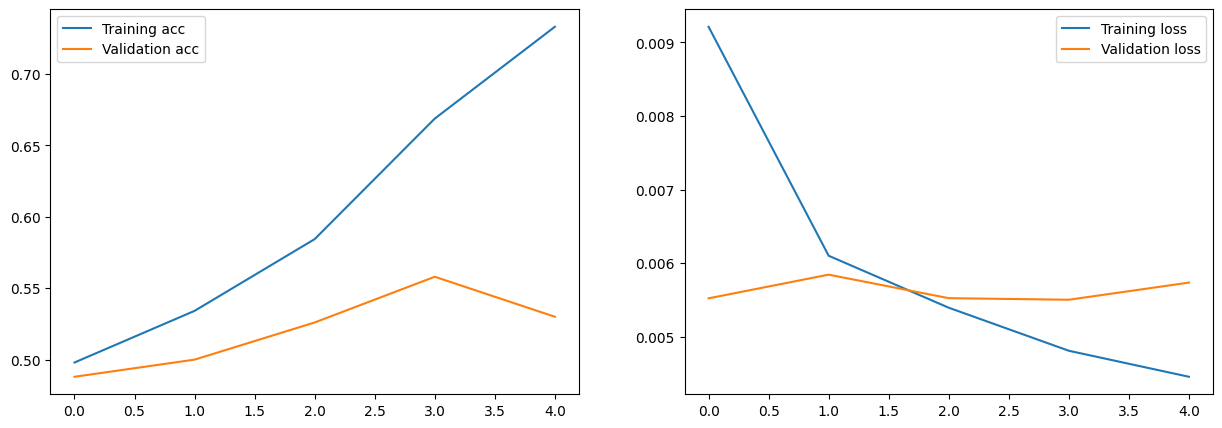

In [16]:
plot_results(hist)

In [17]:
trans

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [18]:
train_augs()

Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

In [19]:
test_augs()

Compose(
    ToTensor()
)

In [20]:
trans

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [21]:
data_train = torchvision.datasets.ImageFolder('./train', transform = common_transform())
data_val = torchvision.datasets.ImageFolder('./test', transform = common_transform())

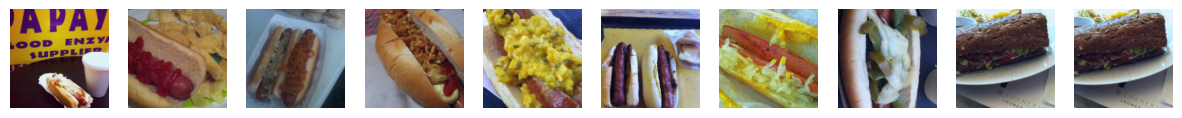

In [22]:
display_dataset(data_train)

In [23]:
img, label = data_train[0]
print(img.shape)

torch.Size([3, 224, 224])


In [24]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size = 128, shuffle = True, pin_memory = True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size = 128, pin_memory = True)

In [25]:
finetune_net = torchvision.models.resnet18(pretrained = True)
print(finetune_net)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[-0.1027, -0.0600,  0.0578,  ..., -0.0765,  0.0945,  0.0370],
        [-0.0587,  0.0841, -0.0422,  ...,  0.0200, -0.0295,  0.0382]],
       requires_grad=True)

In [28]:
finetune_net.to(device);

In [29]:
summary(finetune_net, input_size = [1,3,224,224])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [30]:
def train_fine_tuning(net, train_loader, test_loader, lr, epochs = 5, param_group = True, device = 'cpu', train_mul = False):
    loss = nn.CrossEntropyLoss()
    if param_group:
        names = [name for name, layer in net.named_modules()]
        print(names)
        fc_params = [names[-1]+'.weight', names[-1]+'.bias']
        print(fc_params)
        params_1x = [param for name, param in net.named_parameters() 
        if name not in fc_params]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': getattr(net, names[-1]).parameters(),
                                   'lr': lr*10}], 
                                  lr = lr, momentum = 0.9, nesterov = True)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr = lr, momentum = 0.9, nesterov = True)
    
    if train_mul:
        hist = train_mul(net, train_loader, test_loader, optimizer = trainer, lr=lr, epochs = epochs, loss_fn = loss, devices = try_all_gpus())
    else:
        hist = train(net, train_loader, test_loader, optimizer = trainer, lr = lr, epochs = epochs, loss_fn = loss)
    return hist

In [31]:
hist = train_fine_tuning(finetune_net, train_loader, val_loader,lr = 0.001, device = device)

['', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer1.0', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer2', 'layer2.0', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer3', 'layer3.0', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer4', 'layer4.0', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'layer4.1', 'layer4.1.

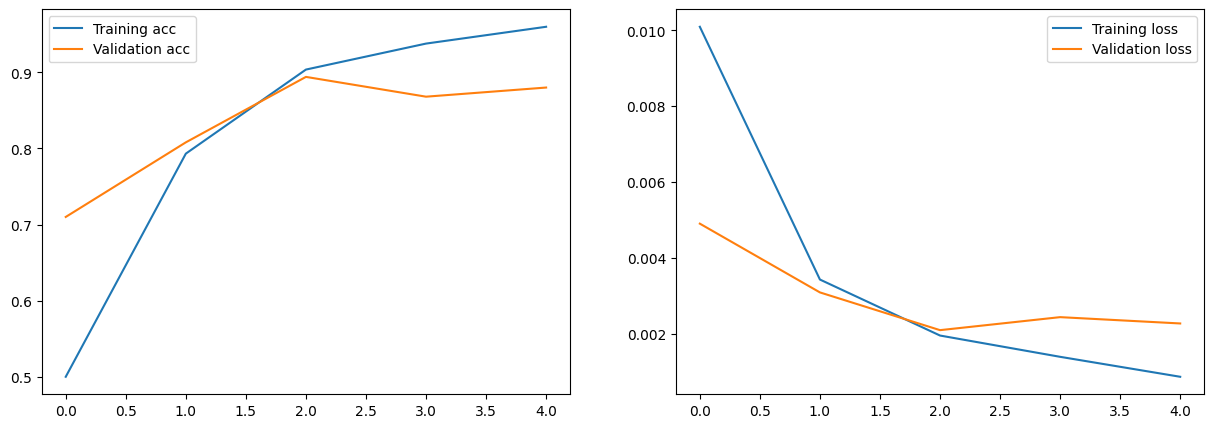

In [32]:
plot_results(hist)

In [12]:
finetune_net2 = torchvision.models.vgg16(pretrained = True)
print(finetune_net2)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 215MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
finetune_net2.classifier = nn.LazyLinear(2)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [14]:
summary(finetune_net2, input_size = [1,3,224,224])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [15]:
finetune_net2.to(device);

In [17]:
hist2 = train_fine_tuning(finetune_net2, train_loader, val_loader,lr = 0.001, device = device, train_multi_gpus = True)

['', 'features', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'classifier']
['classifier.weight', 'classifier.bias']
Epoch  0, Train acc=0.518, Val acc=0.558, Train loss=0.081, Val loss=0.006, Time=13.442
Epoch  1, Train acc=0.608, Val acc=0.502, Train loss=0.005, Val loss=0.006, Time=11.779
Epoch  2, Train acc=0.620, Val acc=0.562, Train loss=0.005, Val loss=0.006, Time=11.989
Epoch  3, Train acc=0.659, Val acc=0.550, Train loss=0.005, Val loss=0.006, Time=11.890
Epoch  4, Train acc=0.667, Val acc=0.576, Train loss=0.005, Val loss=0.005, Time=12.113
